# OSMI Survey 2014 - 2016: Inference

_By [Michael Rosenberg](mailto:mmrosenb@andrew.cmu.edu)._

_**Description**: Contains my notes on the model selected with the mixture for $2014$ and $2016$ data._

_Last Updated: 5/2/2017 9:12 AM._

In [1]:
#imports

#helpers

sigLev = 3

In [5]:
#load in dataset
inferenceFrame = read.csv("../../data/processed/test_timeDep.csv")
#load in model
finalModelFilename = "../../models/finalTimeDepLogRFormula.txt"
finalModelFormula = readChar(finalModelFilename,
                             file.info(finalModelFilename)$size - 1)

In [6]:
finalMod.logr = glm(finalModelFormula,data = inferenceFrame,family = "binomial")

# Diagnostics

In [8]:
#make predictions
inferenceFrame$predictions = predict(finalMod.logr,type = "response")
decRule = 0.5
inferenceFrame$predictions = ifelse(inferenceFrame$predictions > decRule,1,0)
#then check accuracy
accurateFrame = inferenceFrame[which(inferenceFrame$diagnosedWithMHD ==
                                     inferenceFrame$predictions),]
numAccurate = dim(accurateFrame)[1]
propAccurate = numAccurate / dim(inferenceFrame)[1]
print(paste("The proportion accurate is",signif(propAccurate,sigLev)))

[1] "The proportion accurate is 0.582"


This is about on par with our inference performance on our previous model when we just considered the $2016$ data. Let's see how well this is performing in terms of our false positive and false negative rates.

In [9]:
confusionMat = matrix(0,nrow = 2,ncol = 2)
for (i in 1:2){
    for (j in 1:2){
        #get level associated
        confusionMat[i,j] = length(which(inferenceFrame$predictions == i - 1 &
                                inferenceFrame$diagnosedWithMHD == j - 1))
    }
}
#name columns
rownames(confusionMat) = c("Predict 0","Predict 1")
colnames(confusionMat) = c("Actual 0","Actual 1")
confusionMat

,Actual 0,Actual 1
Predict 0,503,388
Predict 1,173,278


_Table 1: Our confusion matrix._

We see that we have a false positive rate of about $\frac{173}{503 + 173} \approx 25.55\%$ and we have a false negative rate of $\frac{388}{278 + 388} \approx 58.26\%.$ This suggests that we are generally undepredicting diagnosis in our current model, which is concerning for the generalization and use of this model.

In [104]:
#get Pearson residuals
residVec = residuals(finalMod.logr,type = "response")
residVec = residVec / sd(predict(finalMod.logr,type = "response"))

pdf 
  2

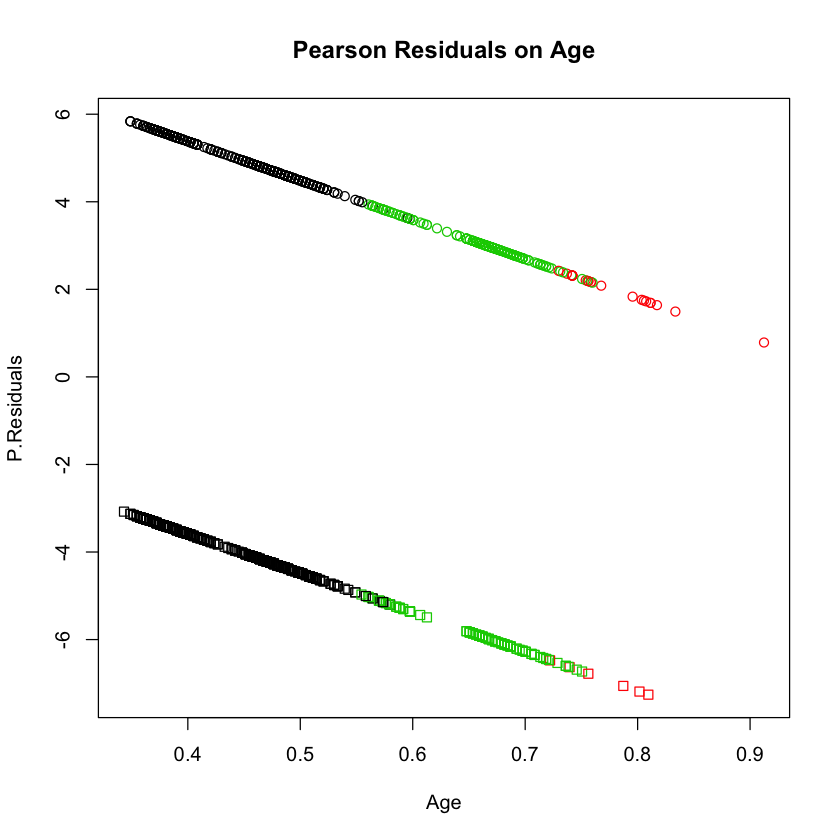

In [107]:
#then plot our residual plots
png("../../reports/thirdBlogPost/figures/figure11.png",res = 400,width = 6,
    height = 6,units = "in")
par(mfrow = c(2,2))
#residual on fitted
plot(residVec ~ fitted(finalMod.logr),xlab = "Fitted",ylab = "P.Residuals",
     main = "Pearson Residuals on Fitted")
abline(0,0,col = "red")
#residual on age
plot(residVec ~ inferenceFrame$age,xlab = "Age",ylab = "P.Residuals",
     main = "Pearson Residuals on Age")
abline(0,0,col = "red")
#residuals on gender
plot(residVec ~ inferenceFrame$gender,xlab = "Gender",ylab = "P.Residuals",
     main = "Pearson Residuals on Gender")
abline(0,0,col = "red")
#residuals on isUSA
plot(residVec ~ factor(inferenceFrame$isUSA),xlab = "isUSA",
     ylab = "P.Residuals",main = "Pearson Residuals on isUSA")
abline(0,0,col = "red")
dev.off()
inferenceFrame$predictions = predict(finalMod.logr,type = "response")
plot(residVec ~ inferenceFrame$predictions,xlab = "Age",ylab = "P.Residuals",
     main = "Pearson Residuals on Age",pch = inferenceFrame$diagnosedWithMHD,
     col = inferenceFrame$gender)

_Figure 1: Our Pearson Residuals on our fitted and predictors._

We see some nonlinearity in residuals on fitted, but this is unfortunately to be expected. We see slight nonlinearity in residuals on age, but it is not very meaningful. The one key nonlinearity is our residuals on gender, where it is apparent that individuals of non-binary genders do not cover the expected $0$ line. This may suggest that our assumptions of linearity may not hold as well for this data.

pdf 
  2

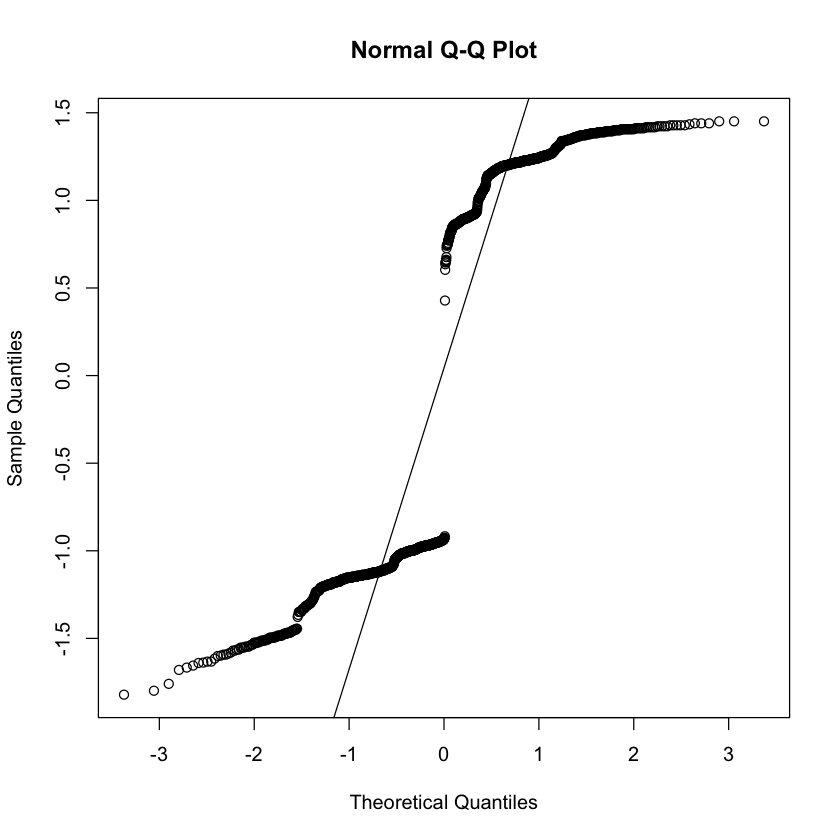

In [88]:
#check that my errors are normally distribution
linkResidVec = residuals(finalMod.logr)
png("../../reports/thirdBlogPost/figures/figure12.png",res = 400,width = 6,
    height = 6,units = "in")
qqnorm(linkResidVec)
qqline(linkResidVec)
dev.off()
qqnorm(linkResidVec)
qqline(linkResidVec)

_Figure 2: Our Q-Q Plot of our residuals._

We see that there is obviously a lack of normality to the errors. Thus, our $p$-values are not interpretable in this state.

# Interpretation

Prior to interpretation, we will build our confidence interval estimates by using a resampling of cases via the bootstrap.

In [60]:
resampleCases <- function(givenFrame){
    #helper for resampling cases from a given dataframe
    sampledCases = sample(1:dim(givenFrame)[1],size = dim(givenFrame)[1],
                          replace = TRUE)
    sampledFrame = givenFrame[sampledCases,]
    return(sampledFrame)
}
simModel <- function(givenFrame,givenFormula){
    #helper for running a simulation of our model
    simFrame = resampleCases(givenFrame)
    simMod.logr = glm(givenFormula,data = simFrame,family = "binomial")
    simModCoeffs = simMod.logr$coefficients
    return(simModCoeffs)
}
performBootstrap <- function(givenFrame,givenFormula,numSims){
    #helper for performing the bootstrap over and over again
    coeffSims = replicate(numSims,simModel(givenFrame,givenFormula))
    
}
#then get upper and lower confidence bounds
numSims = 400
midQ = .5
confInfSize = .95
upperQ = midQ + confInfSize / 2
lowerQ = midQ - confInfSize / 2
bootstrappedCIs = t(apply(
                    performBootstrap(inferenceFrame,finalModelFormula,numSims),
                    1,quantile,c(lowerQ,upperQ)))
print(bootstrappedCIs)

                        2.5%       97.5%
(Intercept)     -1.370271892 -0.38257139
factor(gender)O  0.787610757  2.71236597
factor(gender)W  0.542003602  1.12017837
factor(isUSA)1   0.153221548  0.58891719
age             -0.001383604  0.02783308


In [63]:
coefTable = summary(finalMod.logr)$coefficients
#make it simpler
pValLev = 4
colnames(coefTable)[pValLev] = "p-value"
coefTable = coefTable[,c("Estimate")]
coefTable = cbind(coefTable,bootstrappedCIs)
coefTable = signif(coefTable,sigLev + 1)
colnames(coefTable)[1] = "Estimate"
coefTable

,Estimate,2.5%,97.5%
(Intercept),-0.86340,-1.370000,-0.38260
factor(gender)O,1.59100,0.787600,2.71200
factor(gender)W,0.82960,0.542000,1.12000
factor(isUSA)1,0.36570,0.153200,0.58890
age,0.01262,-0.001384,0.02783


_Table 2: Our Coefficient Table With Bootstrapped $95\%$ confidence intervals._

Because our error model is mis-specified (see Figure 2), it is apparent that the $p$-values are not a good way to interpret these coefficients. Thus, we will limit ourselves to studying effect size.

We see that gender still has a major effect. Currently, we are predicting that on average, a woman is $e^{.8296} = 2.29$ times as likely to be diagnosed with a mental health condition than an equivalent man. This is consistent with the effect found in our [previous analysis](https://medium.com/towards-data-science/data-and-mental-health-the-osmi-survey-2016-39a3d308ac2f). We also have a much more precise estimate on the effect of non-binary individuals, which look to be between $e^{.7876} \approx 2.19$ and $e^{2.712} = 15.059$ times as likely to be diagnosed with a mental health condition than their counterparts who are men.

We see that our age effect is rather weak, as we see that a $0$ effect is in the bootstrapped $95\%$ confidence interval of the estimate. We also see our age interactions dropped from our selection. It is likely that in this case, the effects we studied with for age over time are rather noisy and uncertain.

Our effect of isUSA looks to also be close to what we had in our [previous analysis](https://medium.com/towards-data-science/data-and-mental-health-the-osmi-survey-2016-39a3d308ac2f). However, we now have a strong lower bound of the effect we could consider. In particular, we are $95\%$ confidence that the effect of isUSA is at least $e^{.1532} = 1.16$. This means that we are predicting that an individual working in the US is at least $16\%$ more likely to be diagnosed than an individual not working in the US.

Let's make some pointwise comparisons for US workers who are recent graduates (i.e. $24$ years old).

In [67]:
predictionAge = 24
predictTable = data.frame(gender = c("W","O","M"),isUSA = 1,age = predictionAge)
newPredVec = predict(finalMod.logr,newdata = predictTable,type = "response")
predictTable$prediction = signif(newPredVec,sigLev)
predictTable

gender,isUSA,age,prediction
W,1,24,0.654
O,1,24,0.802
M,1,24,0.451


_Table 3: Our Predictions for recent graduates in the US across gender._

As we can see, for $24$ years old in the US, we are predicting that non-binary individuals are $\frac{.802 - .451}{.451} \cdot 100\% = 77.83\%$ more likely to be diagnosed than men. This is an astonishingly large effect, much larger than our predicted difference for $23$ year-olds in our [previous analysis](https://medium.com/towards-data-science/data-and-mental-health-the-osmi-survey-2016-39a3d308ac2f). Let's try to represent the effect of age by looking at the average age in our inference set.

In [72]:
predictTable$age = signif(mean(inferenceFrame$age),sigLev)
predictTable$prediction = predict(finalMod.logr,newdata = predictTable,
                                  type = "response")
predictTable$prediction = signif(predictTable$prediction,sigLev)
predictTable

gender,isUSA,age,prediction
W,1,33.1,0.679
O,1,33.1,0.819
M,1,33.1,0.480


_Table 4: Our prediction for average-aged individuals in the US across gender._

We see that the predicted effect of age is minimal, despite a $9$ year age gap between the two demographics.

Let's move back to the old age, but consider individuals who are not in the US.

In [74]:
predictTable$age = predictionAge
predictTable$isUSA = 0
predictTable$prediction = predict(finalMod.logr,newdata = predictTable,
                                  type = "response")
predictTable$prediction = signif(predictTable$prediction,sigLev)
predictTable

gender,isUSA,age,prediction
W,0,24,0.567
O,0,24,0.737
M,0,24,0.363


_Table 5:  Our prediction for recent college graduates outside the US across gender._

We see that the non-binary predictive effect is still very stark compared to men.

# Discussion

* We see that our year-based effects seem to drop out of our analysis during the model selection step. This may suggest that we do not have many meaningful differences in the distributions of the $2014$ and $2016$ data. Thus, it suggests that the ongoing demographic effects have stayed consistent during these two time points. This is not surprising given the fact that the industry has not made rapid shifts in its demographic makeup between these two points, despite the efforts for the tech industry to be more gender-inclusive.

* Our gender effect for women and our isUSA effect have stayed consistent between this model and our previous model. Thus, the same narrative questions exist about both of these effects. In particular, because isUK and isCA dropped out of consideration in our model selection step, it may suggest that there is something meaningful about the US' labor landscape that makes the diagnosis rate not simply informed by the fact that the US is a developed country.

* We have a much stronger predictive effect for those of non-binary genders. In particular, we are currently $95\%$ predictively sure that those of non-binary gender are between $4$ and $15$ times more likely to have a diagnosis than their counterparts who are men. Since our gender effect for women is not near to this scale, This suggests that there is some more severe narrative informing the rate of diagnosis for non-binary individuals. This could be something specific to the industry, or this could be something related to society's treatment of non-binary individuals as a whole.

* Our age effect is extremely weak, which is perhaps suggested that our previous model's use of age was somewhat of a decision of overfitting. Overall, this suggests that the rate of diagnosis is not often informed by age. The question I have now is whether in the general population if there is a particular age range where individuals are diagnosed. If there is one, we may need to form a narrative as to why in tech industry, the diagnosis rate is relatively uninformed by age.

# Limitations

In [78]:
numNonBinary = dim(inferenceFrame[inferenceFrame$gender == "O",])[1]
print(numNonBinary)

[1] 27


* The lack of job description in the $2014$ data meant we had to not consider the variable for this analysis. Given that this variable was somewhat relevant to our considerations in our previous analysis, it might have been useful to consider it for our fit.

* We still have a very limited number of nonbinary individuals. It is difficult to get strong estimates of the effect if we are given so few observations to build an effect upon.

* We are predicting slightly better than before, but not by much, and we have a tendency to underpredict diagnosis. This suggests that there are still some demographic variables that we could use to inform this effect.

# Future Work

* Studying the narrative of the gender effect and the isUSA effect

* Seeing how well this model extends to the 2017 data when we create that survey